# Gradient Boosting: a practical guide

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

## An example: the california housing dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import median_absolute_error


calhousing = fetch_california_housing()

X, y = calhousing.data, calhousing.target

In [3]:
print(calhousing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
print(calhousing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=0)

Let's start with a quick baseline model: linear regression (aka. Ordinary Least Squares):

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%time lm = LinearRegression().fit(X_train, y_train)

CPU times: user 11.1 ms, sys: 1.11 ms, total: 12.2 ms
Wall time: 8.61 ms


In [7]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, lm.predict(X_train)),
       median_absolute_error(y_test, lm.predict(X_test))))

train error: 0.413, test error: 0.419


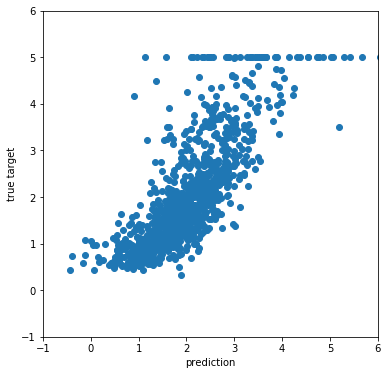

In [8]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(y_pred, y_true)
    
scatter_predictions(lm.predict(X_test), y_test)

This is pretty bad: the errors (off-diagonal predictions) seems to be heteroschedastic and there is a saturation effect with many samples with `y_true == 5`. Let's check:

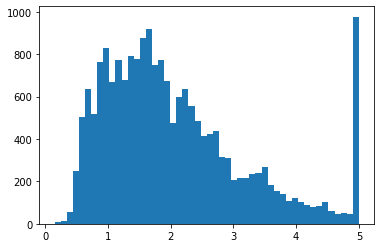

In [9]:
plt.hist(y_train, bins=50);

We can filter out the "anomalies" and make the target variable marginal distribution more "Gaussian" by taking the log:

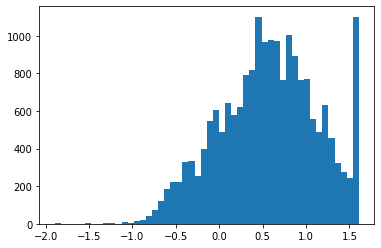

In [10]:
plt.hist(np.log(y_train), bins=50);

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline


lm2 = make_pipeline(
    StandardScaler(),
    TransformedTargetRegressor(LinearRegression(),
                               func=np.log, inverse_func=np.exp)
)
%time _ = lm2.fit(X_train, y_train)

CPU times: user 12.4 ms, sys: 2.77 ms, total: 15.2 ms
Wall time: 14 ms


In [12]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, lm2.predict(X_train)),
       median_absolute_error(y_test, lm2.predict(X_test))))

train error: 0.348, test error: 0.360


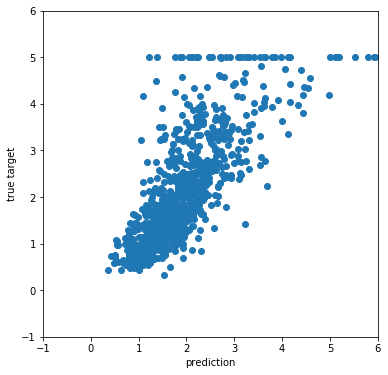

In [13]:
scatter_predictions(lm2.predict(X_test), y_test)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

plm = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=5),
    TransformedTargetRegressor(LinearRegression(),
                               func=np.log, inverse_func=np.exp)
)

%time plm.fit(X_train, y_train)

print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, plm.predict(X_train)),
       median_absolute_error(y_test, plm.predict(X_test))))

CPU times: user 9.27 s, sys: 1.44 s, total: 10.7 s
Wall time: 3.24 s
train error: 0.217, test error: 0.235


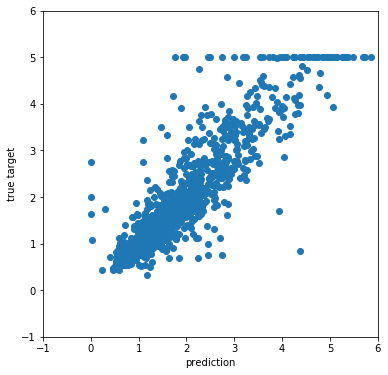

In [15]:
scatter_predictions(plm.predict(X_test), y_test)

In [ ]:
# from sklearn.neural_network import MLPRegressor

# mlp = make_pipeline(
#     StandardScaler(),
#     MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu')
# )
# %time mlp.fit(X_train, y_train)

# print("train error: %0.3f, test error: %0.3f" %
#       (median_absolute_error(y_train, mlp.predict(X_train)),
#        median_absolute_error(y_test, mlp.predict(X_test))))

In [ ]:
# scatter_predictions(mlp.predict(X_test), y_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, n_jobs=2)
%time _ = rfr.fit(X_train, y_train)

CPU times: user 12.5 s, sys: 71.4 ms, total: 12.6 s
Wall time: 6.45 s


In [17]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, rfr.predict(X_train)),
       median_absolute_error(y_test, rfr.predict(X_test))))

train error: 0.074, test error: 0.198


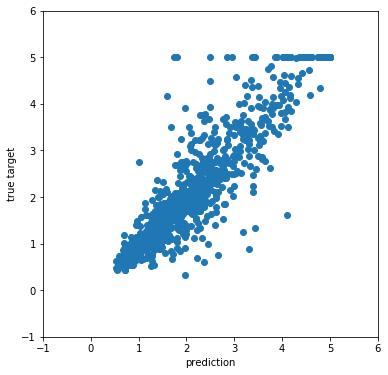

In [18]:
scatter_predictions(rfr.predict(X_test), y_test)

In [19]:
from pickle import dumps
print(f"Model size: {len(dumps(rfr)) / 1e6:.1f} MB")

Model size: 152.3 MB


In [20]:
X_test.shape

(1000, 8)

In [21]:
%timeit -n 3 rfr.predict(X_test)

147 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


### New Histogram-based Gradient Boosting Trees

In [22]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [23]:
hgbr = HistGradientBoostingRegressor(max_leaf_nodes=256)
%time _ = hgbr.fit(X_train, y_train)

CPU times: user 12.3 s, sys: 254 ms, total: 12.6 s
Wall time: 3.37 s


In [24]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, hgbr.predict(X_train)),
       median_absolute_error(y_test, hgbr.predict(X_test))))

train error: 0.103, test error: 0.178


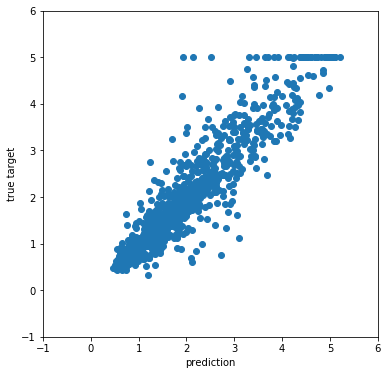

In [25]:
scatter_predictions(hgbr.predict(X_test), y_test)

In [26]:
print(f"Model size: {len(dumps(hgbr)) / 1e6:.1f} MB")

Model size: 2.4 MB


In [27]:
%timeit -n 10 hgbr.predict(X_test)

6.02 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Early stopping

In [28]:
hgbr = HistGradientBoostingRegressor(max_leaf_nodes=256,
                                     n_iter_no_change=10, validation_fraction=0.1,
                                     scoring="loss", max_iter=10000)
%time _ = hgbr.fit(X_train, y_train)

CPU times: user 18.2 s, sys: 163 ms, total: 18.4 s
Wall time: 4.97 s


In [29]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, hgbr.predict(X_train)),
       median_absolute_error(y_test, hgbr.predict(X_test))))

train error: 0.080, test error: 0.172


In [30]:
hgbr.n_iter_

147

In [31]:
print("Model size: %0.1f MB" % (len(dumps(hgbr)) / 1e6))

Model size: 3.6 MB


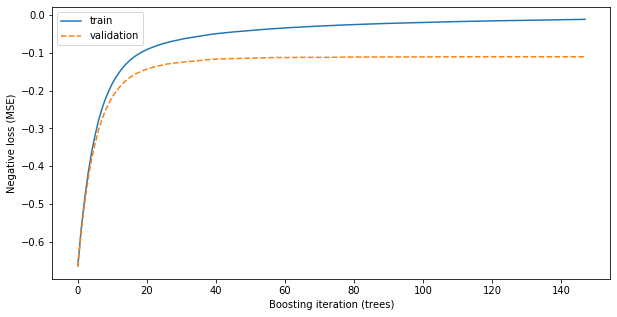

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hgbr.train_score_, label="train")
ax.plot(hgbr.validation_score_, "--", label="validation")
ax.set_xlabel("Boosting iteration (trees)")
ax.set_ylabel("Negative loss (MSE)")
ax.legend();

### Explaining what the model learned

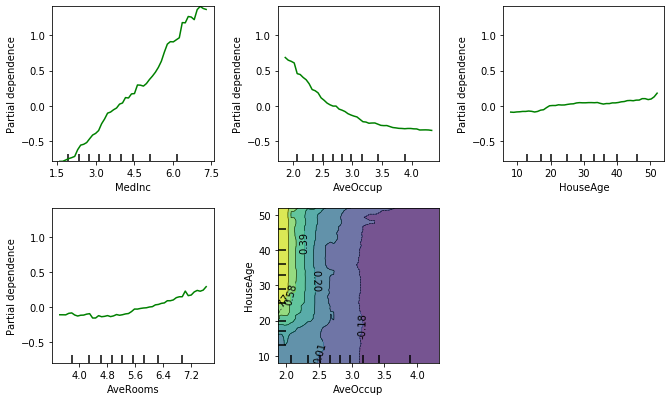

In [33]:
from sklearn.inspection.partial_dependence import plot_partial_dependence

features = [0, 5, 1, 2, (5, 1)]

plot_partial_dependence(hgbr, X_train, features,
                        feature_names=calhousing.feature_names,
                        n_jobs=-1, grid_resolution=50,
                        fig=plt.figure(figsize=(10, 9)))
fig.suptitle('Partial dependence of house value on nonlocation features\n'
             'for the California housing dataset');

## XGBoost and LightGBM

XGBoost and LightGBM provide efficient implementations with many features and a scikit-learn compatible interface. 

They also support out-of-core and distributed model fitting although via a different API.

The new Histogram-based model of scikit-learn should be computationally competitive but (on single machine multithreads) but do not have all their features yet.

In [ ]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=100)
%time xgbr.fit(X_train, y_train)
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, xgbr.predict(X_train)),
       median_absolute_error(y_test, xgbr.predict(X_test))))

In [ ]:
%timeit -n 10 _ = xgbr.predict(X_test)

In [ ]:
print("Model size: %0.1f MB" % (len(dumps(xgbr)) / 1e6))

## Limitations

###  Regression with homogeneous feature interactions

Trees required to approximate X1−X2:

10 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_2.png" />
  
1000 trees:

<img 
  width="50%"
  src="http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/func_approx_minus_3.png" />
  
Credits: https://github.com/pprett/pydata-gbrt-tutorial

### Multiclass classification

The training time, model size and prediction latency of Gradient Boosted Trees scale linearly with the number of classes...

The following are possibly better models for multiclass classification with a large number of classes:

- Random Forests
- Linear models: multi-nomial logistic regression: might require extensive feature engineering to model non-linear interactions in original space. The nystroem method or polynomial features migth be useful in that case.
- Neural Networks (MLP)

### High-dimensional feature spaces

GBRT models tend to work better on lower dimensional space (typically less than 500 features). Using feature importances or other feature selection strategies might help focus the feature engineering effort. But it cannot deal with very high dim bag of words feature for text classification for instance.

For very high-dimensional data, linear models will be much faster to train and possibly yield much better results. GBRT models can still be useful to blend predictions of other models, for instance:

- free text fields in database columns + few numeric or categorical fields
- train one TF-IDF (Bag of Words features) + logistic regression model per free-text field
- train a GBRT model that uses logistic regression models' probabilistic predictions concatenated with numerical and (integer coded) categorical fields to compute the final predictions.